In [ ]:
!pip install -q unsloth sacrebleu rouge_score nltk Levenshtein matplotlib itables
!git clone https://github.com/sunbirdai/salt.git
!pip install -q -r salt/requirements.txt

fatal: destination path 'salt' already exists and is not an empty directory.



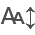

In [ ]:
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm.auto import tqdm
from sacrebleu.metrics import BLEU, CHRF
from rouge_score import rouge_scorer
import Levenshtein
from collections import defaultdict
import transformers
import datasets
import os
import re
import yaml
import salt.constants
import salt.dataset
from transformers.models.whisper.english_normalizer import BasicTextNormalizer
import json
import datetime
import gc

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)

In [ ]:
def load_model(model_path):
    """Load the UG40 model for evaluation."""
    print(f"Loading model from {model_path}...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if 'nllb' in model_path.lower():
        tokenizer = transformers.NllbTokenizer.from_pretrained(model_path)
        model = transformers.M2M100ForConditionalGeneration.from_pretrained(model_path)
    else:
        tokenizer = transformers.AutoTokenizer.from_pretrained(model_path)
        model = transformers.AutoModelForCausalLM.from_pretrained(model_path)
        device = 'cuda' if torch.cuda.is_available() else('cpu')
        model = model.eval().to(device)
    return model, tokenizer, device

def get_language_name(lang_code):
    """Get full language name from ISO code."""
    if lang_code is None:
        return "Unknown"
    return salt.constants.SALT_LANGUAGE_NAMES.get(lang_code, str(lang_code))

In [ ]:
# If a model is already loaded, then free up the VRAM
if 'model' in globals():
    del model
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
# model_path = 'jq/Llama-3.2-3B-Instruct-UG40-16bit-refined-250307'
# model_path = 'jq/Qwen-14B_Instruct-UG40'
# model_path = 'Sunbird/translate-nllb-1.3b-salt'
# model_path = 'jq/Qwen-7B-UG40-LoRA-3-epochs'
model_path = 'jq/nllb-3.3b-salt-lr2e-4'

model, tokenizer, device = load_model(model_path)

In [ ]:
# Set up model-specific inference functions
if 'qwen' in model_path.lower():
    def _get_qwen_response(instructions):
        SYSTEM_MESSAGE = 'You are a Ugandan language assistant.'
        translations = []
        batch_size = 8

        for i in tqdm(range(0, len(instructions), batch_size)):
            batch_instructions = instructions[i:i + batch_size]
            messages_list = [
                [
                    {"role": "system", "content": SYSTEM_MESSAGE},
                    {"role": "user", "content": instruction}
                ] for instruction in batch_instructions
            ]

            prompts = [
                tokenizer.apply_chat_template(
                    messages, tokenize=False, add_generation_prompt=True
                ) for messages in messages_list
            ]

            inputs = tokenizer(
                prompts, return_tensors="pt",
                padding=True, padding_side='left', truncation=True
            ).to(device)

            outputs = model.generate(
                **inputs, max_new_tokens=100,
                temperature=0.5,
                num_beams=5,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_i
            )

            for j in range(len(outputs)):
                translation = tokenizer.decode(
                    outputs[j, inputs['input_ids'].shape[1]:],
                    skip_special_tokens=True
                )
                translations.append(translation)

        return translations

    def translation_fn(texts, from_langs, to_langs):
        assert len(texts) == len(from_langs) == len(to_langs)
        instructions = [
            f'Translate from {get_language_name(from_lang)} '
            f'to {get_language_name(to_lang)}: {text}'
            for text, from_lang, to_lang in zip(texts, from_langs, to_langs)
        ]
        return _get_qwen_response(instructions)

    def dictionary_fn(texts, from_langs, to_langs):
        assert len(texts) == len(from_langs) == len(to_langs)
        instructions = [
            f'Give a dictionary definition of the {get_language_name(from_lang)} term '
            f'"{text}" in {get_language_name(to_lang)}'
            for text, from_lang, to_lang in zip(texts, from_langs, to_langs)
        ]
        return _get_qwen_response(instructions)
elif 'm2m_100' in str(type(model)):
    def translation_fn(texts, source_langs, target_langs):
        translations = []
        language_tokens = salt.constants.SALT_LANGUAGE_TOKENS_NLLB_TRANSLATION
        for text, source_language, target_language in tqdm(
            zip(texts, source_langs, target_langs), total=len(texts)):
            inputs = tokenizer(text, return_tensors="pt").to(device)
            inputs['input_ids'][0][0] = language_tokens[source_language]
            translated_tokens = model.to(device).generate(
                **inputs,
                forced_bos_token_id=language_tokens[target_language],
                max_length=100,
                num_beams=5,
            )
            result = tokenizer.batch_decode(
                translated_tokens, skip_special_tokens=True)[0]
            translations.append(result)
        return translations
elif 'LlamaForCausalLM' in str(type(model.base_model.model)):
    DATE_TODAY = datetime.datetime.now().strftime("%d %b %Y")

    def _get_llama_response(instructions):
        SYSTEM_MESSAGE = ''
        translations = []
        batch_size = 8

        for i in tqdm(range(0, len(instructions), batch_size)):
            batch_instructions = instructions[i:i + batch_size]
            messages_list = [
                [
                    {"role": "system", "content": SYSTEM_MESSAGE},
                    {"role": "user", "content": instruction}
                ] for instruction in batch_instructions
            ]

            prompts = [
                tokenizer.apply_chat_template(
                    messages, tokenize=False, add_generation_prompt=True,
                    date_string=DATE_TODAY,
                ) for messages in messages_list
            ]

            inputs = tokenizer(
                prompts, return_tensors="pt",
                padding=True, padding_side='left', truncation=True
            ).to(device)

            outputs = model.generate(
                **inputs, max_new_tokens=100,
                temperature=0.01,
            )

            for j in range(len(outputs)):
                translation = tokenizer.decode(
                    outputs[j, inputs['input_ids'].shape[1]:],
                    skip_special_tokens=True
                )
                translations.append(translation)

        return translations

    def translation_fn(texts, from_langs, to_langs):
        assert len(texts) == len(from_langs) == len(to_langs)
        instructions = [
            f'Translate from {get_language_name(from_lang)} '
            f'to {get_language_name(to_lang)}: {text}'
            for text, from_lang, to_lang in zip(texts, from_langs, to_langs)
        ]
        return _get_llama_response(instructions)

    def dictionary_fn(texts, from_langs, to_langs):
        assert len(texts) == len(from_langs) == len(to_langs)
        instructions = [
            f'Give a dictionary definition of the {get_language_name(from_lang)} term '
            f'"{text}" in {get_language_name(to_lang)}'
            for text, from_lang, to_lang in zip(texts, from_langs, to_langs)
        ]
        return _get_llama_response(instructions)
else:
    raise ValueError('Translation function for this model not implemented.')

In [ ]:
# Test the translation function
translation_fn(['Hello', 'Oli otya?'], ['eng', 'lug'], ['lug', 'eng'])

  0%|          | 0/2 [00:00<?, ?it/s]

['nkulamusizaako.', 'How are you doing?']

Load the translation test data

In [ ]:
TEST_DATASET = 'salt' # Choose from ['salt', 'bible']
ALL_LANGUAGES = list(salt.constants.SALT_LANGUAGE_NAMES.keys())
ALL_LANGUAGES.remove('ibo')

paths = {'salt': 'sunbird/salt', 'bible': 'Sunbird/external-translation-data'}
names = {'salt': 'text-all', 'bible': 'bibles'}
splits = {'salt': 'dev[:100]', 'bible': 'train[-200:]'}

dataset_config = f'''
huggingface_load:
  path: {paths[TEST_DATASET]}
  name: {names[TEST_DATASET]}
  split: {splits[TEST_DATASET]}
source:
  type: text
  language: {ALL_LANGUAGES}
target:
  type: text
  language: {ALL_LANGUAGES}
src_or_tgt_languages_must_contain: eng
allow_same_src_and_tgt_language: False
'''
config = yaml.safe_load(dataset_config)
translations = pd.DataFrame(salt.dataset.create(config))

In [ ]:
# Generate translations
predictions = translation_fn(
    list(translations['source']),
    list(translations['source.language']),
    list(translations['target.language']),
)
translations['prediction'] = predictions

  0%|          | 0/1600 [00:00<?, ?it/s]

In [ ]:
translations

,source,target,source.language,target.language,prediction
0,Tye yub mapat pat me nyayo lim i cing lwak ma ...,There are a number of wealth creation programs...,ach,eng,There are various outreaches in the agricultur...
1,There are a number of wealth creation programs...,Tye yub mapat pat me nyayo lim i cing lwak ma ...,eng,ach,Yub tye mapol me kelo lonyo ma kwako pur.
2,There are a number of wealth creation programs...,Otita Lonyi eti otizani ꞌdiyi agrikica ma alia...,eng,lgg,Otita lonyi e'dozu agirikica ma dria 'diyi kar...
3,There are a number of wealth creation programs...,Waliwo pulogulaamu nnyingi ez'okweggya mu bwav...,eng,lug,Waliwo pulogulaamu nnyingi ez'okutondawo obuga...
4,There are a number of wealth creation programs...,Hariho puroguraamu nyingi z'okureetaho obugaig...,eng,nyn,Hariho puroguraamu nyingi ezirikureetaho obuga...
...,...,...,...,...,...
1595,Abeegi abarikunywa obuhunga omu shaaha za kyam...,School children who eat porridge during luncht...,nyn,eng,Students who drink alcohol during lunchtime fa...
1596,Watoto wa shule wanaokula uji wakati wa chakul...,School children who eat porridge during luncht...,swa,eng,School children who eat porridge for lunch fal...
1597,Idwe lu esomero lu emasete akuma paran ejotono...,School children who eat porridge during luncht...,teo,eng,Students who smoke cigarettes end up dropping ...
1598,Abaana abasomi abanhwa buugi eky'omusana bawon...,School children who eat porridge during luncht...,xog,eng,Students who take breakfast increase their stu...


Compute the metrics for these predicted translations.

In [ ]:
def calculate_metrics(reference, prediction):
    """Calculate multiple translation quality metrics including ROUGE."""
    bleu = BLEU(effective_order=True)
    bleu_score = bleu.sentence_score(prediction, [reference]).score

    chrf = CHRF()
    chrf_score = chrf.sentence_score(prediction, [reference]).score / 100.0

    cer = Levenshtein.distance(reference, prediction) / max(len(reference), 1)

    ref_words = reference.split()
    pred_words = prediction.split()
    wer = Levenshtein.distance(ref_words, pred_words) / max(len(ref_words), 1)

    len_ratio = len(prediction) / max(len(reference), 1)

    metrics = {
        "bleu": bleu_score,
        "chrf": chrf_score,
        "cer": cer,
        "wer": wer,
        "len_ratio": len_ratio,
    }

    try:
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_scores = scorer.score(reference, prediction)

        metrics["rouge1"] = rouge_scores['rouge1'].fmeasure
        metrics["rouge2"] = rouge_scores['rouge2'].fmeasure
        metrics["rougeL"] = rouge_scores['rougeL'].fmeasure

        metrics["quality_score"] = (
            bleu_score/100 +
            chrf_score +
            (1-cer) +
            (1-wer) +
            rouge_scores['rouge1'].fmeasure +
            rouge_scores['rougeL'].fmeasure
        ) / 6
    except Exception as e:
        print(f"Error calculating ROUGE metrics: {e}")
        metrics["quality_score"] = (bleu_score/100 + chrf_score + (1-cer) + (1-wer)) / 4

    return metrics

In [ ]:
# Group translations by language pair and calculate metrics
translation_subsets = defaultdict(list)
for index, row in translations.iterrows():
    direction = row['source.language'] + '_to_' + row['target.language']
    translation_subsets[direction].append(dict(row))

normalizer = BasicTextNormalizer()
grouped_metrics = defaultdict(dict)
for subset in translation_subsets.keys():
    subset_metrics = defaultdict(list)
    for example in translation_subsets[subset]:
        prediction = normalizer(example['prediction'])
        reference = normalizer(example['target'])
        metrics = calculate_metrics(reference, prediction)
        for m in metrics.keys():
            subset_metrics[m].append(metrics[m])
    for m in subset_metrics.keys():
        grouped_metrics[subset][m] = float(np.mean(subset_metrics[m]))

In [ ]:
# Calculate overall averages
for m in subset_metrics.keys():
    metric_values = []
    for subset in translation_subsets.keys():
        metric_values.append(grouped_metrics[subset][m])
    grouped_metrics['averages'][m] = float(np.mean(metric_values))


In [ ]:
print(json.dumps(grouped_metrics, indent=4))

{
    "ach_to_eng": {
        "bleu": 25.87927141584623,
        "chrf": 0.5039673079761469,
        "cer": 0.45831347848249115,
        "wer": 0.5877300893550893,
        "len_ratio": 1.010971363169451,
        "rouge1": 0.5797139175911556,
        "rouge2": 0.3398998664985192,
        "rougeL": 0.5571050238787152,
        "quality_score": 0.47558923262781655
    },
    "eng_to_ach": {
        "bleu": 18.47187486486482,
        "chrf": 0.4877975754938861,
        "cer": 0.4547388733437391,
        "wer": 0.6715387698984583,
        "len_ratio": 0.9777214040412068,
        "rouge1": 0.4858089563836589,
        "rouge2": 0.2462771820192712,
        "rougeL": 0.46435888491068456,
        "quality_score": 0.4160677536991133
    },
    "eng_to_lgg": {
        "bleu": 19.460159167652726,
        "chrf": 0.4955293581731969,
        "cer": 0.5019988658615981,
        "wer": 0.7337096645670477,
        "len_ratio": 1.0543406380159157,
        "rouge1": 0.5442727067942109,
        "rouge2": 0.2

In [ ]:
if 'model_metrics' not in globals():
    model_metrics = {}
model_metrics[model_path] = grouped_metrics

### Plot translation performance for this model only

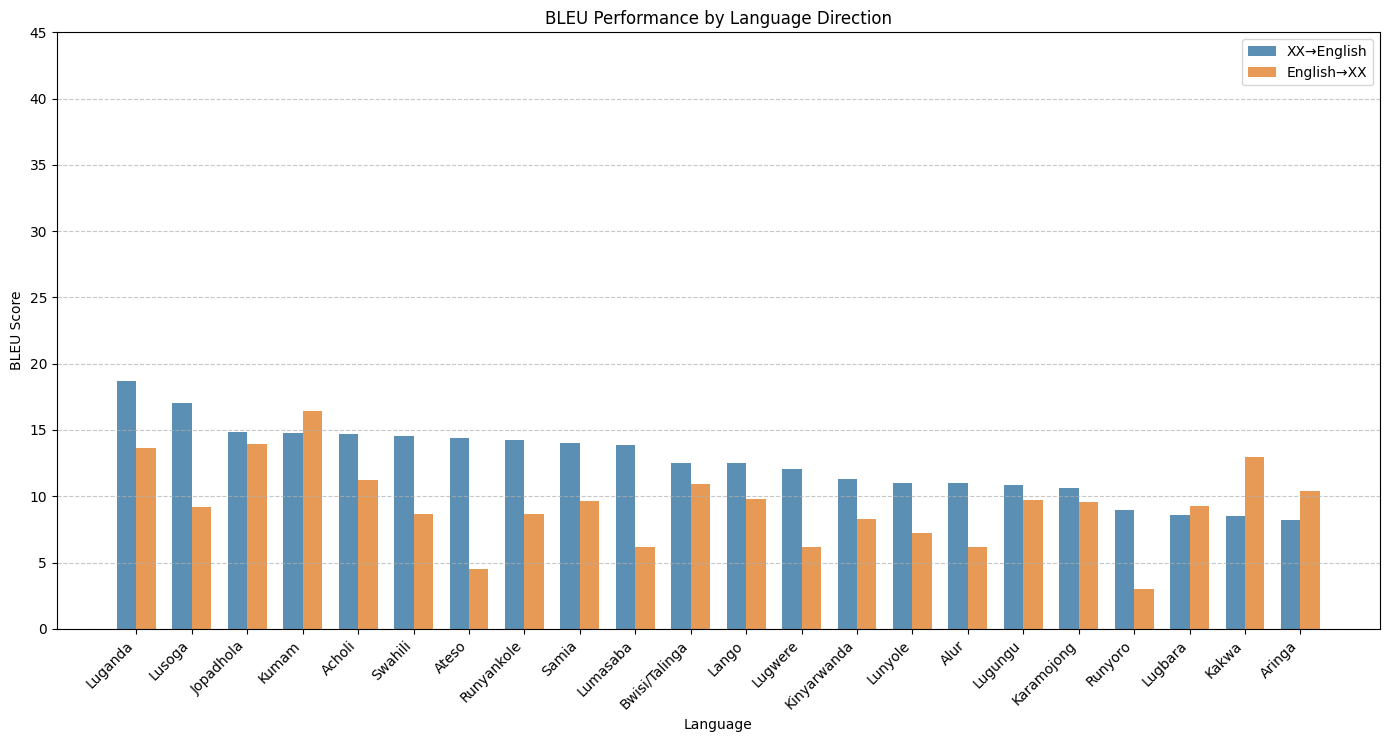

In [ ]:
def plot_translation_metric_comparison_single_model(model_metrics, metric='bleu'):
    """
    Creates a single plot comparing a selected metric for a single translation model.
    Shows both xx_to_eng and eng_to_xx for each language, ordered by xx_to_eng performance.

    Parameters:
    metrics_by_model (dict): Dictionary containing metrics for each model and language pair
    selected_model (str): The model to display
    metric (str): The metric to compare (e.g., 'bleu', 'chrf', 'wer', etc.)
    """
    # Get xx_to_eng and eng_to_xx language pairs
    xx_to_eng = [key for key in model_metrics.keys()
                if key.endswith('_to_eng') and key != 'averages']
    eng_to_xx = [key for key in model_metrics.keys()
                if key.startswith('eng_to_') and key != 'averages']

    # Create a mapping of language codes to full names
    language_codes = [lang.replace('_to_eng', '') for lang in xx_to_eng]

    # Function to create nice labels
    def format_label(lang_code):
        return salt.constants.SALT_LANGUAGE_NAMES[lang_code]

    # Extract BLEU scores for ordering
    xx_to_eng_scores = {lang.replace('_to_eng', ''): model_metrics[lang][metric]
                        for lang in xx_to_eng}

    # Sort languages by xx_to_eng score (highest to lowest)
    languages_sorted = sorted(language_codes,
                              key=lambda x: xx_to_eng_scores[x],
                              reverse=True)

    # Extract metric values for both directions
    xx_to_eng_values = []
    eng_to_xx_values = []

    for lang in languages_sorted:
        xx_to_eng_values.append(model_metrics[f"{lang}_to_eng"][metric])
        # Make sure the corresponding eng_to_xx entry exists
        if f"eng_to_{lang}" in eng_to_xx:
            eng_to_xx_values.append(model_metrics[f"eng_to_{lang}"][metric])
        else:
            eng_to_xx_values.append(None)  # Use None for missing values

    # Remove None values and adjust languages_sorted
    valid_indices = [i for i, val in enumerate(eng_to_xx_values) if val is not None]
    languages_sorted = [languages_sorted[i] for i in valid_indices]
    xx_to_eng_values = [xx_to_eng_values[i] for i in valid_indices]
    eng_to_xx_values = [eng_to_xx_values[i] for i in valid_indices]

    # Set up plot
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    opacity = 0.8

    # Positions for the bars
    indices = np.arange(len(languages_sorted))

    # Colors for the directions
    xx_to_eng_color = '#3274A1'  # Blue
    eng_to_xx_color = '#E1812C'  # Orange

    # Determine y-axis limits based on metric
    if metric in ['chrf', 'len_ratio']:  # Metrics that are typically between 0 and 1
        y_max = 1.1
    elif metric in ['cer', 'wer']:  # Error rates (lower is better)
        y_max = 1.0
    elif metric == 'bleu':  # BLEU scores typically 0-100
        y_max = 45
    elif metric in ['rouge1', 'rouge2', 'rougeL']:  # ROUGE scores typically 0-1
        y_max = 1.0
    elif metric == 'quality_score':
        y_max = 0.65
    else:
        y_max = max(xx_to_eng_values + eng_to_xx_values) * 1.1

    # Format metric name for display
    metric_display = metric.upper() if metric in ['bleu', 'chrf', 'cer', 'wer'] else metric.replace('_', ' ').title()

    # Create bars
    plt.bar(indices - bar_width/2, xx_to_eng_values, bar_width,
            alpha=opacity, color=xx_to_eng_color, label='XX→English')
    plt.bar(indices + bar_width/2, eng_to_xx_values, bar_width,
            alpha=opacity, color=eng_to_xx_color, label='English→XX')

    plt.xlabel('Language')
    plt.ylabel(f'{metric_display} Score')
    plt.title(f'{metric_display} Performance by Language Direction')
    plt.xticks(indices, [format_label(lang) for lang in languages_sorted], rotation=45, ha='right')
    plt.ylim(0, y_max)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Add note for metrics where lower is better
    if metric in ['cer', 'wer']:
        plt.figtext(0.5, 0.01, "Note: Lower values indicate better performance for this metric",
                   ha='center', fontsize=12, style='italic')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    plt.savefig(f'{metric}_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_translation_metric_comparison_single_model(grouped_metrics, metric='bleu')

### Compare performance of different models

In [ ]:
def plot_translation_metric_comparison(metrics_by_model, metric='bleu'):
    """
    Creates a grouped bar chart comparing a selected metric across translation models.

    Parameters:
    metrics_by_model (dict): Dictionary containing metrics for each model and language pair
    metric (str): The metric to compare (e.g., 'bleu', 'chrf', 'wer', etc.)
    """
    # Split language pairs into xx_to_eng and eng_to_xx categories
    xx_to_eng = [key for key in metrics_by_model[list(metrics_by_model.keys())[0]].keys()
                if key.endswith('_to_eng') and key != 'averages']
    eng_to_xx = [key for key in metrics_by_model[list(metrics_by_model.keys())[0]].keys()
                if key.startswith('eng_to_') and key != 'averages']

    # Function to create nice labels
    def format_label(label):
        if label.startswith("eng_to_"):
            source, target = "English", label.replace("eng_to_", "")
            target = salt.constants.SALT_LANGUAGE_NAMES[target]
        else:
            source, target = label.replace("_to_eng", ""), "English"
            source = salt.constants.SALT_LANGUAGE_NAMES[source]
        return f"{source}→{target}"

    # Extract metric values for each category
    def extract_metric_values(model_metrics, pairs, metric_name):
        return [model_metrics[pair][metric_name] for pair in pairs]

    xx_to_eng_data = {
        model_name: extract_metric_values(model_data, xx_to_eng, metric)
        for model_name, model_data in metrics_by_model.items()
    }

    eng_to_xx_data = {
        model_name: extract_metric_values(model_data, eng_to_xx, metric)
        for model_name, model_data in metrics_by_model.items()
    }

    averages_data = {
        model_name: [model_data["averages"][metric]]
        for model_name, model_data in metrics_by_model.items()
    }

    # Set up plot
    plt.figure(figsize=(18, 10))
    bar_width = 0.25
    opacity = 0.8

    # Positions for the bars
    xx_to_eng_indices = np.arange(len(xx_to_eng))
    eng_to_xx_indices = np.arange(len(eng_to_xx))
    avg_index = np.array([0])

    # Colors for the models
    colors = ['#3274A1', '#E1812C', '#3A923A']
    model_names = list(metrics_by_model.keys())

    # Determine y-axis limits based on metric
    if metric in ['chrf', 'len_ratio']:  # Metrics that are typically between 0 and 1
        y_max = 1.1
    elif metric in ['cer', 'wer']:  # Error rates (lower is better)
        y_max = 1.0
    elif metric == 'bleu':  # BLEU scores typically 0-100
        y_max = 45
    elif metric in ['rouge1', 'rouge2', 'rougeL']:  # ROUGE scores typically 0-1
        y_max = 1.0
    elif metric == 'quality_score':
        y_max = 0.65
    else:
        y_max = max([max(data) for data in xx_to_eng_data.values()] +
                    [max(data) for data in eng_to_xx_data.values()] +
                    [max(data) for data in averages_data.values()]) * 1.1

    # Format metric name for display
    metric_display = metric.upper() if metric in ['bleu', 'chrf', 'cer', 'wer'] else metric.replace('_', ' ').title()

    # Create bars for xx_to_eng
    plt.subplot(1, 3, 1)
    for i, (model_name, color) in enumerate(zip(model_names, colors)):
        plt.bar(xx_to_eng_indices + i*bar_width, xx_to_eng_data[model_name],
                bar_width, alpha=opacity, color=color, label=model_name)

    plt.xlabel('Translation Direction')
    plt.ylabel(f'{metric_display} Score')
    plt.title(f'XX→English {metric_display} Performance')
    plt.xticks(xx_to_eng_indices + bar_width, [format_label(label) for label in xx_to_eng], rotation=45, ha='right')
    plt.ylim(0, y_max)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Create bars for eng_to_xx
    plt.subplot(1, 3, 2)
    for i, (model_name, color) in enumerate(zip(model_names, colors)):
        plt.bar(eng_to_xx_indices + i*bar_width, eng_to_xx_data[model_name],
                bar_width, alpha=opacity, color=color, label=model_name)

    plt.xlabel('Translation Direction')
    plt.ylabel(f'{metric_display} Score')
    plt.title(f'English→XX {metric_display} Performance')
    plt.xticks(eng_to_xx_indices + bar_width, [format_label(label) for label in eng_to_xx], rotation=45, ha='right')
    plt.ylim(0, y_max)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Create bars for averages
    plt.subplot(1, 3, 3)
    for i, (model_name, color) in enumerate(zip(model_names, colors)):
        plt.bar(avg_index + i*bar_width, averages_data[model_name],
                bar_width, alpha=opacity, color=color, label=model_name)

    plt.xlabel('Overall')
    plt.ylabel(f'{metric_display} Score')
    plt.title(f'Average {metric_display} Across All Language Pairs')
    plt.xticks(avg_index + bar_width, ['Average'])
    plt.ylim(0, y_max)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Add note for metrics where lower is better
    if metric in ['cer', 'wer']:
        plt.figtext(0.5, 0.01, "Note: Lower values indicate better performance for this metric",
                   ha='center', fontsize=12, style='italic')

    # Add an overall title and adjust layout
    model_list = ' vs '.join(model_names)
    plt.suptitle(f'{metric_display} Score Comparison: {model_list}', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.02, 1, 0.95])

    plt.savefig(f'translation_models_{metric}_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

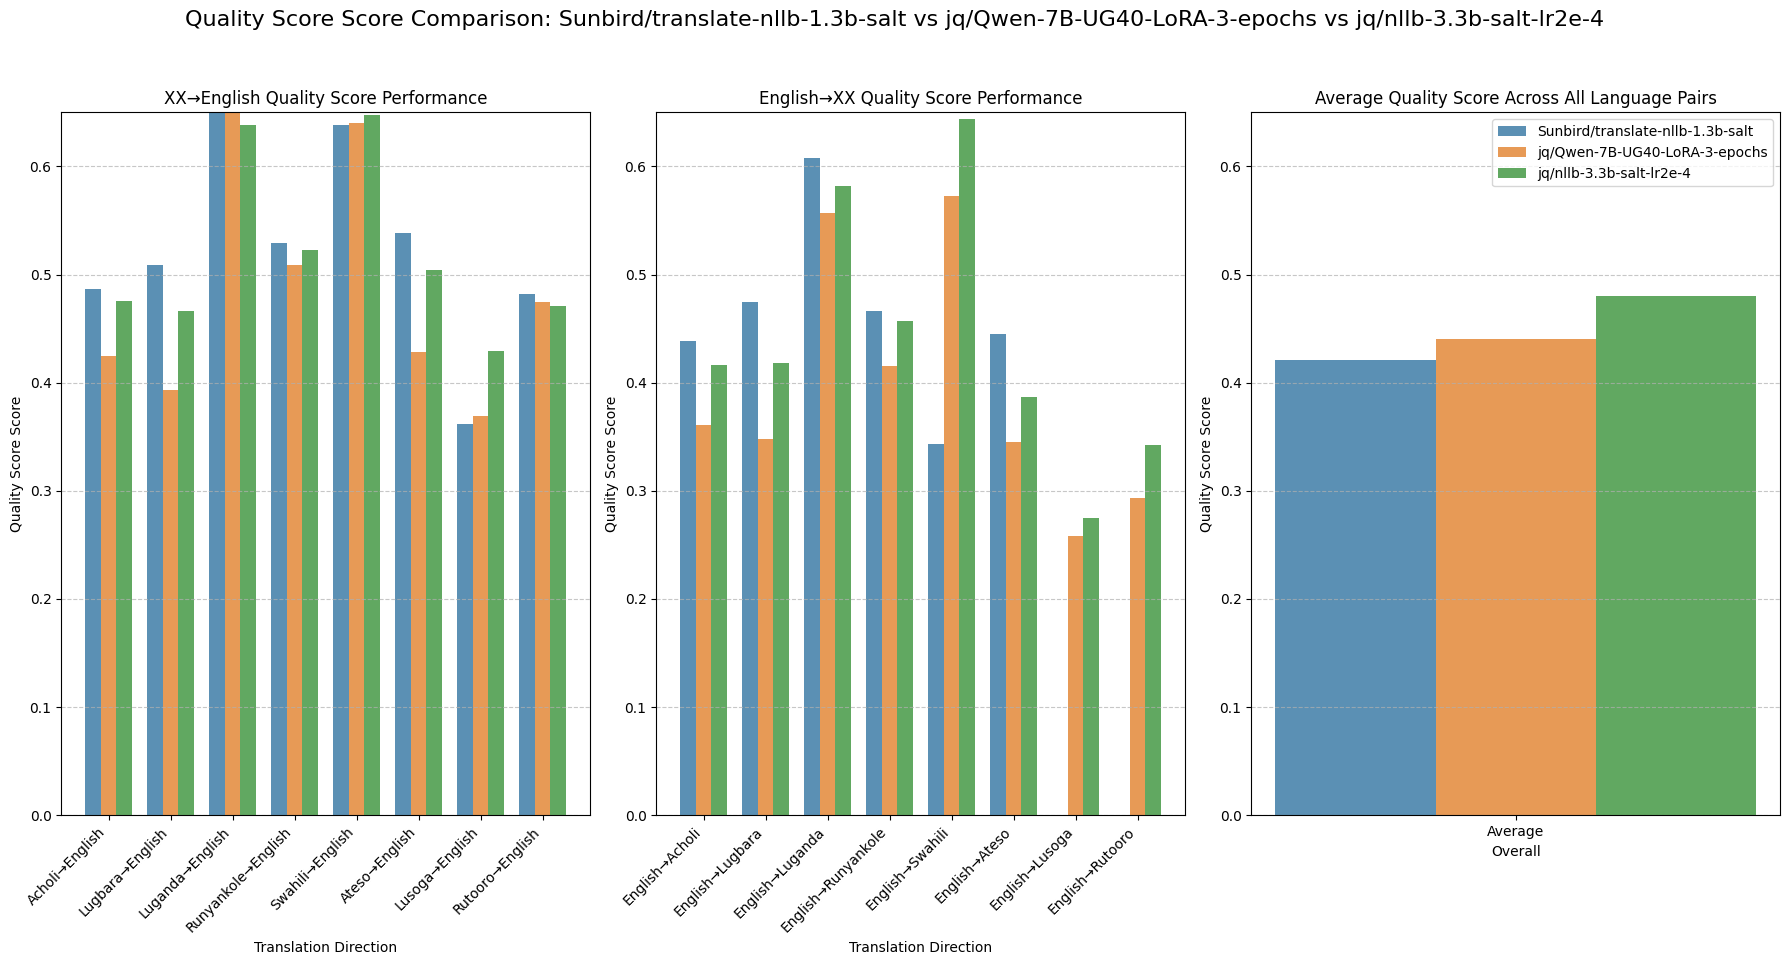

In [ ]:
plot_translation_metric_comparison(model_metrics, 'quality_score')

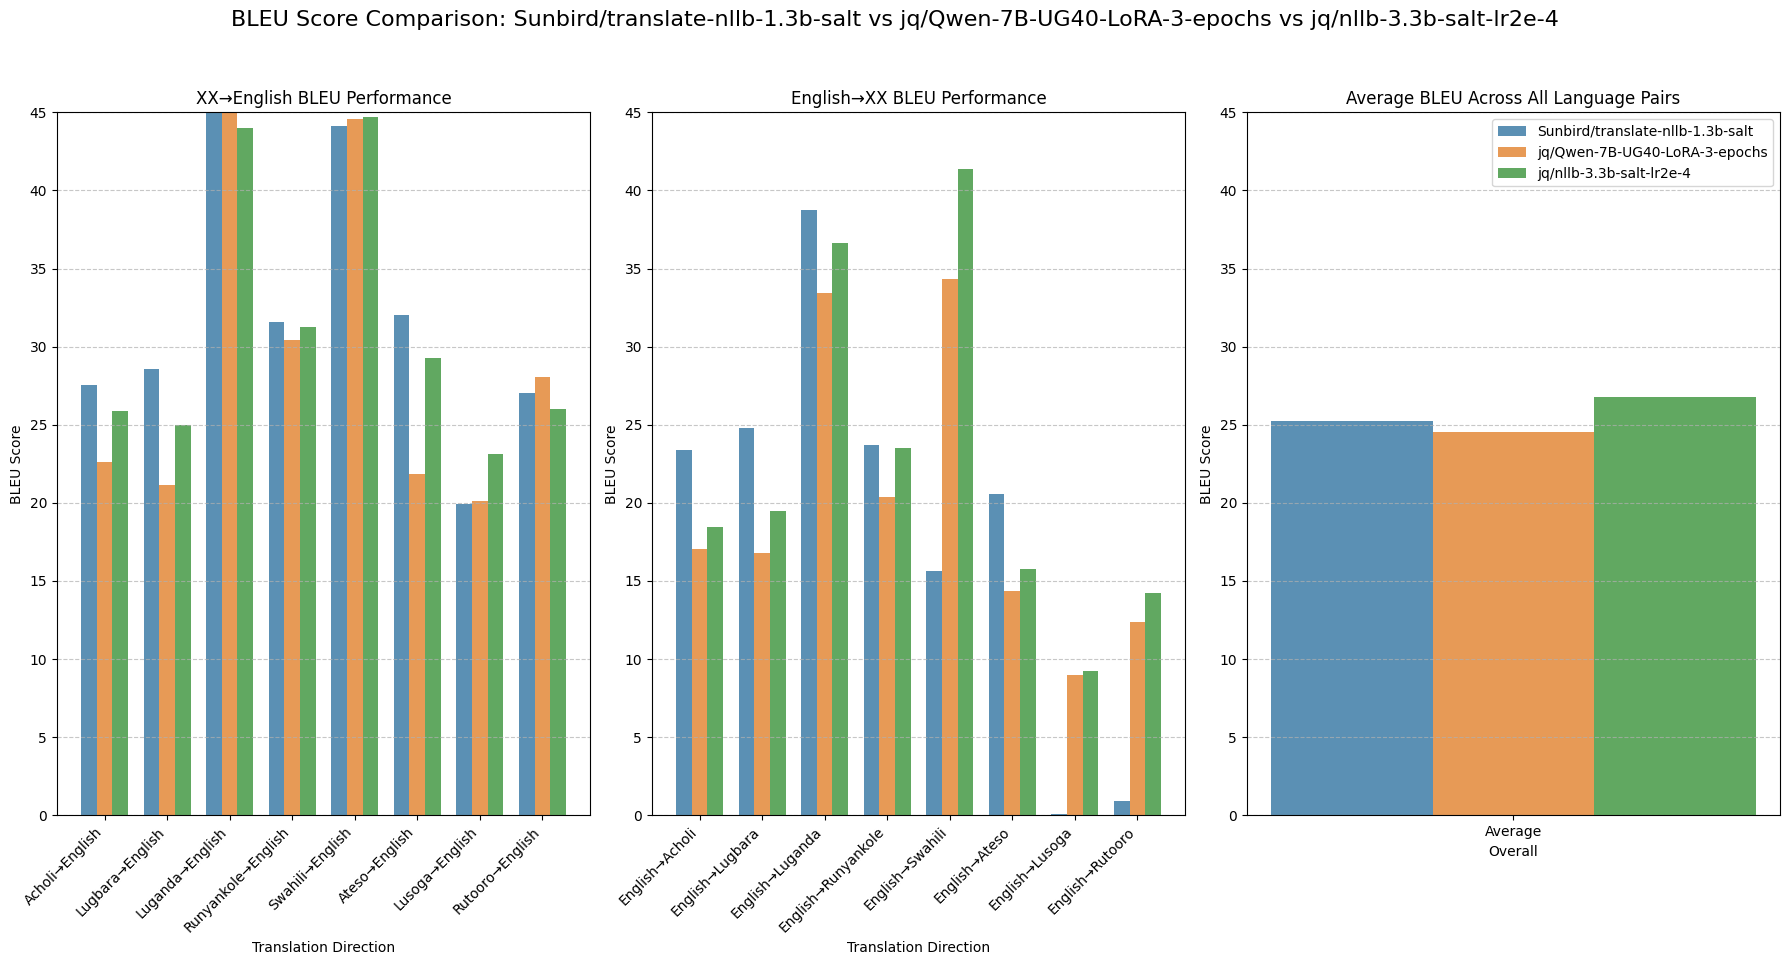

In [ ]:
plot_translation_metric_comparison(model_metrics, 'bleu')

In [ ]:
# Some pre-computed results on salt dev[:100] subset.
model_metrics = {'Sunbird/translate-nllb-1.3b-salt': {'ach_to_eng': {'bleu': 27.55466701616264,
                                                                 'chrf': 0.5152946815288163,
                                                                 'cer': 0.45218837416128127,
                                                                 'wer': 0.5796315212565213,
                                                                 'len_ratio': 0.9797749251635527,
                                                                 'rouge1': 0.5901186805104788,
                                                                 'rouge2': 0.34903903712220957,
                                                                 'rougeL': 0.5727841952765966,
                                                                 'quality_score': 0.4869873886766192},
                                                  'eng_to_ach': {'bleu': 23.38036422798187,
                                                                 'chrf': 0.5124679541944236,
                                                                 'cer': 0.4590834365142328,
                                                                 'wer': 0.6589492642159891,
                                                                 'len_ratio': 0.995164803892353,
                                                                 'rouge1': 0.5153443615014368,
                                                                 'rouge2': 0.29601830235259774,
                                                                 'rougeL': 0.48906561028870504,
                                                                 'quality_score': 0.4387748112556937},
                                                  'eng_to_lgg': {'bleu': 24.805728629946387,
                                                                 'chrf': 0.5405549105278005,
                                                                 'cer': 0.43407632529668433,
                                                                 'wer': 0.6493519010266889,
                                                                 'len_ratio': 1.0277302882186234,
                                                                 'rouge1': 0.5896664150679611,
                                                                 'rouge2': 0.33955302521555303,
                                                                 'rougeL': 0.552144931902713,
                                                                 'quality_score': 0.4744992195790942},
                                                  'eng_to_lug': {'bleu': 38.740432078537594,
                                                                 'chrf': 0.7053794947024867,
                                                                 'cer': 0.27965431362240706,
                                                                 'wer': 0.45554340104340096,
                                                                 'len_ratio': 1.017749515270381,
                                                                 'rouge1': 0.6504448826745204,
                                                                 'rouge2': 0.4463253408220975,
                                                                 'rougeL': 0.641146497823504,
                                                                 'quality_score': 0.6081962468866798},
                                                  'eng_to_nyn': {'bleu': 23.670769533167213,
                                                                 'chrf': 0.6203457167627553,
                                                                 'cer': 0.3940384411288068,
                                                                 'wer': 0.657529193029193,
                                                                 'len_ratio': 1.047680764282978,
                                                                 'rouge1': 0.5000378051696278,
                                                                 'rouge2': 0.2713049605079017,
                                                                 'rougeL': 0.49129363513955127,
                                                                 'quality_score': 0.46613620304093445},
                                                  'eng_to_swa': {'bleu': 15.614670747345468,
                                                                 'chrf': 0.416078538398838,
                                                                 'cer': 0.5016889154851873,
                                                                 'wer': 0.7335070346320345,
                                                                 'len_ratio': 0.9718336414160241,
                                                                 'rouge1': 0.365462651076657,
                                                                 'rouge2': 0.15663192669492307,
                                                                 'rougeL': 0.35495869510830474,
                                                                 'quality_score': 0.3429084403233387},
                                                  'eng_to_teo': {'bleu': 20.556977501984697,
                                                                 'chrf': 0.5810091571380289,
                                                                 'cer': 0.43909867027545835,
                                                                 'wer': 0.6728784548784549,
                                                                 'len_ratio': 1.1171322007821844,
                                                                 'rouge1': 0.5083016131836798,
                                                                 'rouge2': 0.25017458935826026,
                                                                 'rougeL': 0.489348871041891,
                                                                 'quality_score': 0.44537538187158887},
                                                  'eng_to_xog': {'bleu': 0.08745825313180626,
                                                                 'chrf': 0.029427287595634274,
                                                                 'cer': 1.043138740906667,
                                                                 'wer': 1.34957683982684,
                                                                 'len_ratio': 0.4885857694155788,
                                                                 'rouge1': 0.002,
                                                                 'rouge2': 0.0,
                                                                 'rougeL': 0.002,
                                                                 'quality_score': -0.05973561843442574},
                                                  'eng_to_ttj': {'bleu': 0.9001381749290275,
                                                                 'chrf': 0.1209846252421799,
                                                                 'cer': 1.1183403325154488,
                                                                 'wer': 2.09498667998668,
                                                                 'len_ratio': 1.2722443312447362,
                                                                 'rouge1': 0.026645903645045523,
                                                                 'rouge2': 0.005017032967032967,
                                                                 'rougeL': 0.026645903645045523,
                                                                 'quality_score': -0.1716748663700946},
                                                  'lgg_to_eng': {'bleu': 28.57153371621622,
                                                                 'chrf': 0.550800320058701,
                                                                 'cer': 0.44069802608982384,
                                                                 'wer': 0.5743035436785436,
                                                                 'len_ratio': 1.0211453684296332,
                                                                 'rouge1': 0.6326012928990636,
                                                                 'rouge2': 0.37550385006358844,
                                                                 'rougeL': 0.5978717217531304,
                                                                 'quality_score': 0.5086645170174483},
                                                  'lug_to_eng': {'bleu': 45.67154151962936,
                                                                 'chrf': 0.6512155288197183,
                                                                 'cer': 0.3025101690390744,
                                                                 'wer': 0.37358775946275946,
                                                                 'len_ratio': 0.982524446865254,
                                                                 'rouge1': 0.7387194195127016,
                                                                 'rouge2': 0.5423803332908053,
                                                                 'rougeL': 0.7234699765838057,
                                                                 'quality_score': 0.6490037352684476},
                                                  'nyn_to_eng': {'bleu': 31.602815405141953,
                                                                 'chrf': 0.5515834000472223,
                                                                 'cer': 0.39792980561759456,
                                                                 'wer': 0.5259126567876566,
                                                                 'len_ratio': 0.9666392481590255,
                                                                 'rouge1': 0.624369452763669,
                                                                 'rouge2': 0.39047055857554164,
                                                                 'rougeL': 0.6048543363503223,
                                                                 'quality_score': 0.5288321468012303},
                                                  'swa_to_eng': {'bleu': 44.118217036122275,
                                                                 'chrf': 0.6451143733216944,
                                                                 'cer': 0.31101870601004633,
                                                                 'wer': 0.38694644244644244,
                                                                 'len_ratio': 0.9585479891070254,
                                                                 'rouge1': 0.7280292821122595,
                                                                 'rouge2': 0.5353707365193299,
                                                                 'rougeL': 0.7110431142590841,
                                                                 'quality_score': 0.637900631932962},
                                                  'teo_to_eng': {'bleu': 32.00774797577287,
                                                                 'chrf': 0.5642098611632034,
                                                                 'cer': 0.39456578854297625,
                                                                 'wer': 0.5206783355533355,
                                                                 'len_ratio': 0.9751181005968286,
                                                                 'rouge1': 0.6415597031233237,
                                                                 'rouge2': 0.40966629145147787,
                                                                 'rougeL': 0.620964046947083,
                                                                 'quality_score': 0.5385944944825045},
                                                  'xog_to_eng': {'bleu': 19.91943113290698,
                                                                 'chrf': 0.4062298886066259,
                                                                 'cer': 0.5732653332608996,
                                                                 'wer': 0.7313788156288158,
                                                                 'len_ratio': 1.0432988165834711,
                                                                 'rouge1': 0.44138562848065843,
                                                                 'rouge2': 0.2508087793310771,
                                                                 'rougeL': 0.42796039860018564,
                                                                 'quality_score': 0.3616876796878041},
                                                  'ttj_to_eng': {'bleu': 27.04467425732136,
                                                                 'chrf': 0.4965497878249732,
                                                                 'cer': 0.4516261786379153,
                                                                 'wer': 0.571468253968254,
                                                                 'len_ratio': 1.01739911620794,
                                                                 'rouge1': 0.5814895041820453,
                                                                 'rouge2': 0.3389579617291993,
                                                                 'rougeL': 0.5641860685620927,
                                                                 'quality_score': 0.48159627842269254},
                                                  'averages': {'bleu': 25.265447950393607,
                                                               'chrf': 0.49420284537081893,
                                                               'cer': 0.4995575973190315,
                                                               'wer': 0.7210143810888506,
                                                               'len_ratio': 0.9926605828522244,
                                                               'rouge1': 0.5085110372439455,
                                                               'rouge2': 0.30982642037509966,
                                                               'rougeL': 0.4918586252051259,
                                                               'quality_score': 0.42110916815265736}},
 'jq/Qwen-7B-UG40-LoRA-3-epochs': {'ach_to_eng': {'bleu': 22.59811346697323,
                                                              'chrf': 0.4704240922983377,
                                                              'cer': 0.5009023377010754,
                                                              'wer': 0.678433927183927,
                                                              'len_ratio': 1.0085055343235714,
                                                              'rouge1': 0.5250538292669107,
                                                              'rouge2': 0.291923739217902,
                                                              'rougeL': 0.5037823799735801,
                                                              'quality_score': 0.4243175285539264},
                                               'eng_to_ach': {'bleu': 17.07175985027237,
                                                              'chrf': 0.45617362257157235,
                                                              'cer': 0.5322875588417153,
                                                              'wer': 0.7764053245235942,
                                                              'len_ratio': 1.0342533748743201,
                                                              'rouge1': 0.4341131398016186,
                                                              'rouge2': 0.2134775553083193,
                                                              'rougeL': 0.41290185851836875,
                                                              'quality_score': 0.3608688893381622},
                                               'eng_to_lgg': {'bleu': 16.76722615438318,
                                                              'chrf': 0.4459092269277991,
                                                              'cer': 0.5845960364523358,
                                                              'wer': 0.8652412948286216,
                                                              'len_ratio': 1.118497714707596,
                                                              'rouge1': 0.4814468757854823,
                                                              'rouge2': 0.22431359599838013,
                                                              'rougeL': 0.4445407853981702,
                                                              'quality_score': 0.34828863639572105},
                                               'eng_to_lug': {'bleu': 33.43949058042144,
                                                              'chrf': 0.6624807788221405,
                                                              'cer': 0.31414510028466786,
                                                              'wer': 0.5108216505716505,
                                                              'len_ratio': 1.0368172402665217,
                                                              'rouge1': 0.5842923802346189,
                                                              'rouge2': 0.3969519208425522,
                                                              'rougeL': 0.5825516394938782,
                                                              'quality_score': 0.5564588255830889},
                                               'eng_to_nyn': {'bleu': 20.345154075564675,
                                                              'chrf': 0.5812238679103777,
                                                              'cer': 0.4499667785936098,
                                                              'wer': 0.7380625346875346,
                                                              'len_ratio': 1.0894397332303125,
                                                              'rouge1': 0.4536745621458031,
                                                              'rouge2': 0.23942060750733227,
                                                              'rougeL': 0.44262218968166595,
                                                              'quality_score': 0.41549047453539145},
                                               'eng_to_swa': {'bleu': 34.35081491226519,
                                                              'chrf': 0.6456602802973945,
                                                              'cer': 0.3277556449879711,
                                                              'wer': 0.470291847041847,
                                                              'len_ratio': 1.0593925707257006,
                                                              'rouge1': 0.6302680854941759,
                                                              'rouge2': 0.4158410035623533,
                                                              'rougeL': 0.6134803764323249,
                                                              'quality_score': 0.5724782332194549},
                                               'eng_to_teo': {'bleu': 14.344791932273315,
                                                              'chrf': 0.478470059014706,
                                                              'cer': 0.5433212080799098,
                                                              'wer': 0.7916338106338106,
                                                              'len_ratio': 1.1545790271735143,
                                                              'rouge1': 0.3990245979057461,
                                                              'rouge2': 0.15122935277283103,
                                                              'rougeL': 0.3822097183408665,
                                                              'quality_score': 0.3446995459783886},
                                               'eng_to_xog': {'bleu': 8.97490609667626,
                                                              'chrf': 0.40841411713745046,
                                                              'cer': 0.5079114016316,
                                                              'wer': 0.9117814130314131,
                                                              'len_ratio': 1.015678798960088,
                                                              'rouge1': 0.23519386477863066,
                                                              'rouge2': 0.07211079105407599,
                                                              'rougeL': 0.2335550687920086,
                                                              'quality_score': 0.25786988283530654},
                                               'eng_to_ttj': {'bleu': 12.375587570001196,
                                                              'chrf': 0.4643057840713876,
                                                              'cer': 0.5500836626591746,
                                                              'wer': 0.9150225885225884,
                                                              'len_ratio': 1.106756114104483,
                                                              'rouge1': 0.3214256215563636,
                                                              'rouge2': 0.12123632132194105,
                                                              'rougeL': 0.3138052708925347,
                                                              'quality_score': 0.29303105017308906},
                                               'lgg_to_eng': {'bleu': 21.138469175605998,
                                                              'chrf': 0.4364443034408287,
                                                              'cer': 0.5448708353428475,
                                                              'wer': 0.7148574342324341,
                                                              'len_ratio': 1.0118196881229986,
                                                              'rouge1': 0.49815409307933967,
                                                              'rouge2': 0.26851958014017513,
                                                              'rougeL': 0.4716304238423982,
                                                              'quality_score': 0.3929808737572241},
                                               'lug_to_eng': {'bleu': 45.61671939987784,
                                                              'chrf': 0.6595263080010737,
                                                              'cer': 0.2930067985462723,
                                                              'wer': 0.369611901986902,
                                                              'len_ratio': 0.9781766775190043,
                                                              'rouge1': 0.7395700894869341,
                                                              'rouge2': 0.5480956064809342,
                                                              'rougeL': 0.7243524083951898,
                                                              'quality_score': 0.6528328832248002},
                                               'nyn_to_eng': {'bleu': 30.42785861502802,
                                                              'chrf': 0.5324514855263733,
                                                              'cer': 0.413733196802464,
                                                              'wer': 0.5503041264291264,
                                                              'len_ratio': 0.9723649534208143,
                                                              'rouge1': 0.6006574573027751,
                                                              'rouge2': 0.37532928429014034,
                                                              'rougeL': 0.5773437850016885,
                                                              'quality_score': 0.5084489984582545},
                                               'swa_to_eng': {'bleu': 44.60045219910818,
                                                              'chrf': 0.6481578749219042,
                                                              'cer': 0.29988144519520654,
                                                              'wer': 0.3876133727383727,
                                                              'len_ratio': 0.9893216086971266,
                                                              'rouge1': 0.7223592766521156,
                                                              'rouge2': 0.539609412844959,
                                                              'rougeL': 0.7121514174846656,
                                                              'quality_score': 0.640196378852698},
                                               'teo_to_eng': {'bleu': 21.87318289655574,
                                                              'chrf': 0.45839110535057315,
                                                              'cer': 0.49623211994618627,
                                                              'wer': 0.6535910339660339,
                                                              'len_ratio': 0.9845315280398228,
                                                              'rouge1': 0.5359964148485516,
                                                              'rouge2': 0.28684501031896514,
                                                              'rougeL': 0.5055476533832308,
                                                              'quality_score': 0.42814064143928215},
                                               'xog_to_eng': {'bleu': 20.12463222129214,
                                                              'chrf': 0.4238558356413619,
                                                              'cer': 0.5825838507790967,
                                                              'wer': 0.7705335636585637,
                                                              'len_ratio': 1.076455205148364,
                                                              'rouge1': 0.482131942672677,
                                                              'rouge2': 0.24812725593655732,
                                                              'rougeL': 0.4601031971999956,
                                                              'quality_score': 0.36903664721488255},
                                               'ttj_to_eng': {'bleu': 28.030466030474436,
                                                              'chrf': 0.49500000136155514,
                                                              'cer': 0.4636566171298056,
                                                              'wer': 0.5985404734154733,
                                                              'len_ratio': 1.0110553546099361,
                                                              'rouge1': 0.5758342835841761,
                                                              'rouge2': 0.35567520396774666,
                                                              'rougeL': 0.55829403828434,
                                                              'quality_score': 0.47453931549825606},
                                               'averages': {'bleu': 24.504976573548326,
                                                            'chrf': 0.5166805464559272,
                                                            'cer': 0.46280841206087114,
                                                            'wer': 0.6689216435907432,
                                                            'len_ratio': 1.040477820245261,
                                                            'rouge1': 0.5136997821622449,
                                                            'rouge2': 0.2967941400978228,
                                                            'rougeL': 0.4961795131946817,
                                                            'quality_score': 0.4399799253161204}},
 'jq/nllb-3.3b-salt-lr2e-4': {'ach_to_eng': {'bleu': 25.87927141584623,
                                                         'chrf': 0.5039673079761469,
                                                         'cer': 0.45831347848249115,
                                                         'wer': 0.5877300893550893,
                                                         'len_ratio': 1.010971363169451,
                                                         'rouge1': 0.5797139175911556,
                                                         'rouge2': 0.3398998664985192,
                                                         'rougeL': 0.5571050238787152,
                                                         'quality_score': 0.47558923262781655},
                                          'eng_to_ach': {'bleu': 18.47187486486482,
                                                         'chrf': 0.4877975754938861,
                                                         'cer': 0.4547388733437391,
                                                         'wer': 0.6715387698984583,
                                                         'len_ratio': 0.9777214040412068,
                                                         'rouge1': 0.4858089563836589,
                                                         'rouge2': 0.2462771820192712,
                                                         'rougeL': 0.46435888491068456,
                                                         'quality_score': 0.4160677536991133},
                                          'eng_to_lgg': {'bleu': 19.460159167652726,
                                                         'chrf': 0.4955293581731969,
                                                         'cer': 0.5019988658615981,
                                                         'wer': 0.7337096645670477,
                                                         'len_ratio': 1.0543406380159157,
                                                         'rouge1': 0.5442727067942109,
                                                         'rouge2': 0.2775552449093105,
                                                         'rougeL': 0.5096895384966373,
                                                         'quality_score': 0.4180641107853211},
                                          'eng_to_lug': {'bleu': 36.604527671749835,
                                                         'chrf': 0.6886356956473082,
                                                         'cer': 0.29778723750738006,
                                                         'wer': 0.4820628815628816,
                                                         'len_ratio': 1.0274695874133104,
                                                         'rouge1': 0.6130794819664598,
                                                         'rouge2': 0.4244413637165607,
                                                         'rougeL': 0.6058939166357331,
                                                         'quality_score': 0.5823007086494563},
                                          'eng_to_nyn': {'bleu': 23.497570645953914,
                                                         'chrf': 0.6197186741168065,
                                                         'cer': 0.4053797775246538,
                                                         'wer': 0.6844145854145854,
                                                         'len_ratio': 1.063856363798552,
                                                         'rouge1': 0.4963104812921925,
                                                         'rouge2': 0.2801064720487669,
                                                         'rougeL': 0.48239959952127015,
                                                         'quality_score': 0.45726834974176156},
                                          'eng_to_swa': {'bleu': 41.39426957313926,
                                                         'chrf': 0.7058297142780332,
                                                         'cer': 0.2527483011313829,
                                                         'wer': 0.3729686147186147,
                                                         'len_ratio': 1.0372115163327558,
                                                         'rouge1': 0.6883752438795008,
                                                         'rouge2': 0.4928887128603723,
                                                         'rougeL': 0.6802314530298276,
                                                         'quality_score': 0.6437770318447927},
                                          'eng_to_teo': {'bleu': 15.77959024907701,
                                                         'chrf': 0.5168027078041971,
                                                         'cer': 0.48100297149204363,
                                                         'wer': 0.7240192030192029,
                                                         'len_ratio': 1.1110296443998708,
                                                         'rouge1': 0.43158991155198356,
                                                         'rouge2': 0.17492029709421011,
                                                         'rougeL': 0.4215048551051624,
                                                         'quality_score': 0.38711186707347783},
                                          'eng_to_xog': {'bleu': 9.241325306056854,
                                                         'chrf': 0.42625268217805257,
                                                         'cer': 0.48970469280569207,
                                                         'wer': 0.8788972138972139,
                                                         'len_ratio': 0.9813512550131911,
                                                         'rouge1': 0.2509709657003536,
                                                         'rouge2': 0.07609386405262887,
                                                         'rougeL': 0.24598913173254489,
                                                         'quality_score': 0.27450402099476895},
                                          'eng_to_ttj': {'bleu': 14.239525034561762,
                                                         'chrf': 0.48104183468259476,
                                                         'cer': 0.4934868036646198,
                                                         'wer': 0.8105156926406927,
                                                         'len_ratio': 1.070484665467596,
                                                         'rouge1': 0.3703774365808858,
                                                         'rouge2': 0.14607757522909628,
                                                         'rougeL': 0.3628367347095992,
                                                         'quality_score': 0.3421081266688975},
                                          'lgg_to_eng': {'bleu': 24.9818625923481,
                                                         'chrf': 0.49645509783954217,
                                                         'cer': 0.47059415505487157,
                                                         'wer': 0.6091360861360862,
                                                         'len_ratio': 0.9954767764962904,
                                                         'rouge1': 0.578452143726613,
                                                         'rouge2': 0.33249484311050476,
                                                         'rougeL': 0.5528895726298516,
                                                         'quality_score': 0.4663141998214217},
                                          'lug_to_eng': {'bleu': 43.99361669283522,
                                                         'chrf': 0.6422803146431515,
                                                         'cer': 0.3077123870140589,
                                                         'wer': 0.378095251970252,
                                                         'len_ratio': 0.9774355227539586,
                                                         'rouge1': 0.7248247461718522,
                                                         'rouge2': 0.5305922066200501,
                                                         'rougeL': 0.7101889438903976,
                                                         'quality_score': 0.6385704221082404},
                                          'nyn_to_eng': {'bleu': 31.249723001653525,
                                                         'chrf': 0.5387552784587524,
                                                         'cer': 0.40572325697537837,
                                                         'wer': 0.5320085608835609,
                                                         'len_ratio': 0.9751551175745748,
                                                         'rouge1': 0.6216165874662173,
                                                         'rouge2': 0.39426397244639266,
                                                         'rougeL': 0.6002637298274531,
                                                         'quality_score': 0.5225668346516698},
                                          'swa_to_eng': {'bleu': 44.6997343914571,
                                                         'chrf': 0.6562651408521525,
                                                         'cer': 0.29541752099353097,
                                                         'wer': 0.3708158924408923,
                                                         'len_ratio': 0.9820847308057873,
                                                         'rouge1': 0.7298928342600454,
                                                         'rouge2': 0.5413290651470176,
                                                         'rougeL': 0.7171922103164339,
                                                         'quality_score': 0.6473523526514633},
                                          'teo_to_eng': {'bleu': 29.251403906214513,
                                                         'chrf': 0.5205340195011332,
                                                         'cer': 0.4258250711268968,
                                                         'wer': 0.5521534299034299,
                                                         'len_ratio': 0.979166267902333,
                                                         'rouge1': 0.607618919679897,
                                                         'rouge2': 0.37217708790613613,
                                                         'rougeL': 0.5830375298998699,
                                                         'quality_score': 0.5042876678521198},
                                          'xog_to_eng': {'bleu': 23.135726922889948,
                                                         'chrf': 0.4655415786305371,
                                                         'cer': 0.5006319151124098,
                                                         'wer': 0.6535498251748251,
                                                         'len_ratio': 1.025562570639383,
                                                         'rouge1': 0.5282296403335116,
                                                         'rouge2': 0.29882205576438986,
                                                         'rougeL': 0.5074785025298212,
                                                         'quality_score': 0.42973754173925577},
                                          'ttj_to_eng': {'bleu': 26.03431904468742,
                                                         'chrf': 0.48377336503041946,
                                                         'cer': 0.46414332515258827,
                                                         'wer': 0.5972064463314463,
                                                         'len_ratio': 1.0066132374738386,
                                                         'rouge1': 0.5783379127943318,
                                                         'rouge2': 0.33667870836586444,
                                                         'rougeL': 0.5628273279666177,
                                                         'quality_score': 0.4706553374590348},
                                          'averages': {'bleu': 26.744656280061765,
                                                       'chrf': 0.5455737715816193,
                                                       'cer': 0.41907553957770843,
                                                       'wer': 0.6024263879946425,
                                                       'len_ratio': 1.017245666331126,
                                                       'rouge1': 0.5518419928858045,
                                                       'rouge2': 0.32903865736181825,
                                                       'rougeL': 0.5352429346925387,
                                                       'quality_score': 0.47976722239803826}}}

# **Dictionary Evaluation**

In [ ]:
def token_overlap(str1, str2):
    """Calculate token overlap between two strings."""
    tokens1 = set(str1.lower().split())
    tokens2 = set(str2.lower().split())

    if not tokens1 or not tokens2:
        return 0.0

    intersection = tokens1.intersection(tokens2)
    union = tokens1.union(tokens2)

    return len(intersection) / len(union)

In [ ]:
# Dictionary Evaluation
print("\n=== Dictionary Evaluation ===")
# try:
dictionary_data = load_dataset('Sunbird/ug40', 'dictionaries', split='train')
print(f"Using dictionary dev split with {len(dictionary_data)} examples")
# except ValueError:
#     print("Dev split not found, creating evaluation set from train split")
#     dictionary_full = load_dataset('Sunbird/ug40', 'dictionaries', split='train')
#     train_test_split = dictionary_full.train_test_split(test_size=0.2, seed=42)
#     dictionary_data = train_test_split['test']
#     print(f"Created evaluation set with {len(dictionary_data)} examples")



=== Dictionary Evaluation ===
Using dictionary dev split with 66412 examples


In [ ]:
# Filter valid dictionary entries
filtered_data = []
for example in dictionary_data:
    if (example.get('Key') and
        example.get('from_language') and
        example.get('to_language') and
        example.get('Definition')):

        if (example['from_language'] in salt.constants.SALT_LANGUAGE_NAMES and
            example['to_language'] in salt.constants.SALT_LANGUAGE_NAMES):
            filtered_data.append(example)

print(f"Filtered to {len(filtered_data)} valid entries")

Filtered to 12028 valid entries


In [ ]:
# Create dataset from filtered data
valid_dictionary_data = datasets.Dataset.from_dict({
    k: [example[k] for example in filtered_data]
    for k in filtered_data[0].keys() if filtered_data
})

In [ ]:
# Optional: Limit samples for faster evaluation
max_samples = 150  # Set to a number or None to use all data

if max_samples and max_samples < len(valid_dictionary_data):
    # Sample from each language pair to maintain balance
    language_pairs = {}

    for i, item in enumerate(valid_dictionary_data):
        pair = (item['from_language'], item['to_language'])
        if pair not in language_pairs:
            language_pairs[pair] = []
        language_pairs[pair].append(i)

    indices = []
    samples_per_pair = max(1, max_samples // len(language_pairs))
    for pair, pair_indices in language_pairs.items():
        indices.extend(pair_indices[:min(samples_per_pair, len(pair_indices))])
        if len(indices) >= max_samples:
            break

    indices = indices[:max_samples]
    dictionary_subset = valid_dictionary_data.select(indices)
    print(f"Selected {len(dictionary_subset)} examples for evaluation")
else:
    dictionary_subset = valid_dictionary_data
    print(f"Using all {len(dictionary_subset)} examples for evaluation")

Selected 132 examples for evaluation


In [ ]:
# Extract data for dictionary evaluation
terms = []
from_langs = []
to_langs = []
references = []

for example in dictionary_subset:
    terms.append(example['Key'])
    from_langs.append(example['from_language'])
    to_langs.append(example['to_language'])
    references.append(example['Definition'])

# Generate dictionary definitions
print("Generating dictionary definitions...")
predictions = dictionary_fn(terms, from_langs, to_langs)

Generating dictionary definitions...


  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
# Create DataFrame with results
dict_df = pd.DataFrame({
    'term': terms,
    'from_language': from_langs,
    'to_language': to_langs,
    'reference': references,
    'prediction': predictions
})


In [ ]:
def calculate_dict_metrics(reference, prediction):
    """Calculate similarity metrics for dictionary definitions."""
    token_sim = token_overlap(reference, prediction)
    char_sim = 1 - Levenshtein.distance(reference, prediction) / max(len(reference), len(prediction), 1)

    metrics = {
        "token_similarity": token_sim,
        "char_similarity": char_sim,
    }

    try:
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_scores = scorer.score(reference, prediction)

        metrics["rouge1"] = rouge_scores['rouge1'].fmeasure
        metrics["rouge2"] = rouge_scores['rouge2'].fmeasure
        metrics["rougeL"] = rouge_scores['rougeL'].fmeasure

        metrics["quality_score"] = (
            token_sim +
            char_sim +
            rouge_scores['rouge1'].fmeasure +
            rouge_scores['rougeL'].fmeasure
        ) / 4
    except Exception as e:
        metrics["quality_score"] = (token_sim + char_sim) / 2

    return metrics

In [ ]:
# Group dictionary entries by language pair
dict_subsets = defaultdict(list)
for index, row in dict_df.iterrows():
    direction = row['from_language'] + '_to_' + row['to_language']
    dict_subsets[direction].append(dict(row))

print(f"Found {len(dict_subsets)} language direction pairs")

Found 14 language direction pairs


In [ ]:
# Calculate metrics for each language pair
dict_metrics = defaultdict(dict)
for subset_name in dict_subsets.keys():
    subset = dict_subsets[subset_name]
    subset_metrics = defaultdict(list)

    for example in subset:
        prediction = normalizer(example['prediction'])
        reference = normalizer(example['reference'])

        metrics = calculate_dict_metrics(reference, prediction)
        for m in metrics.keys():
            subset_metrics[m].append(metrics[m])

    for m in subset_metrics.keys():
        dict_metrics[subset_name][m] = float(np.mean(subset_metrics[m]))

In [ ]:
# Calculate overall averages
for m in list(next(iter(dict_metrics.values())).keys()):
    metric_values = []
    for subset in dict_metrics.keys():
        if subset != 'averages' and m in dict_metrics[subset]:
            metric_values.append(dict_metrics[subset][m])

    if metric_values:
        dict_metrics['averages'][m] = float(np.mean(metric_values))

# Print results
print(json.dumps(dict_metrics, indent=4))

{
    "eng_to_nuj": {
        "token_similarity": 0.0,
        "char_similarity": 0.24994605214315485,
        "rouge1": 0.0,
        "rouge2": 0.0,
        "rougeL": 0.0,
        "quality_score": 0.06248651303578871
    },
    "nuj_to_eng": {
        "token_similarity": 0.050293571163136375,
        "char_similarity": 0.16805504771752075,
        "rouge1": 0.05748438380791321,
        "rouge2": 0.0,
        "rougeL": 0.039302565626095035,
        "quality_score": 0.07878389207866635
    },
    "nyn_to_eng": {
        "token_similarity": 0.05917818740399385,
        "char_similarity": 0.12420757962441949,
        "rouge1": 0.08380342870381095,
        "rouge2": 0.03333333333333333,
        "rougeL": 0.081556237692575,
        "quality_score": 0.08718635835619983
    },
    "eng_to_lug": {
        "token_similarity": 0.1805858395989975,
        "char_similarity": 0.26716181483692203,
        "rouge1": 0.18493625367767244,
        "rouge2": 0.005555555555555555,
        "rougeL": 0.18493

In [ ]:
# Visualize dictionary metrics
def plot_dictionary_metrics():
    language_pairs = [pair for pair in dict_metrics.keys() if pair != 'averages']

    if len(language_pairs) > 10:
        language_pairs = sorted(
            language_pairs,
            key=lambda x: dict_metrics[x].get('quality_score', 0),
            reverse=True
        )[:10]

    # Token similarity by language pair
    plt.figure(figsize=(12, 6))
    token_similarities = [dict_metrics[pair]['token_similarity'] for pair in language_pairs]
    plt.bar(language_pairs, token_similarities, color='skyblue')
    plt.title('Token Similarity by Language Pair')
    plt.xlabel('Language Pair')
    plt.ylabel('Token Similarity')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Quality score by language pair
    plt.figure(figsize=(12, 6))
    quality_scores = [dict_metrics[pair]['quality_score'] for pair in language_pairs]
    plt.bar(language_pairs, quality_scores, color='lightgreen')
    plt.title('Dictionary Quality Score by Language Pair')
    plt.xlabel('Language Pair')
    plt.ylabel('Quality Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Average metrics
    plt.figure(figsize=(10, 6))
    metrics = ['token_similarity', 'char_similarity', 'rouge1', 'rougeL', 'quality_score']
    averages = [dict_metrics['averages'].get(m, 0) for m in metrics]
    plt.bar(metrics, averages, color='salmon')
    plt.title('Average Dictionary Evaluation Metrics')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

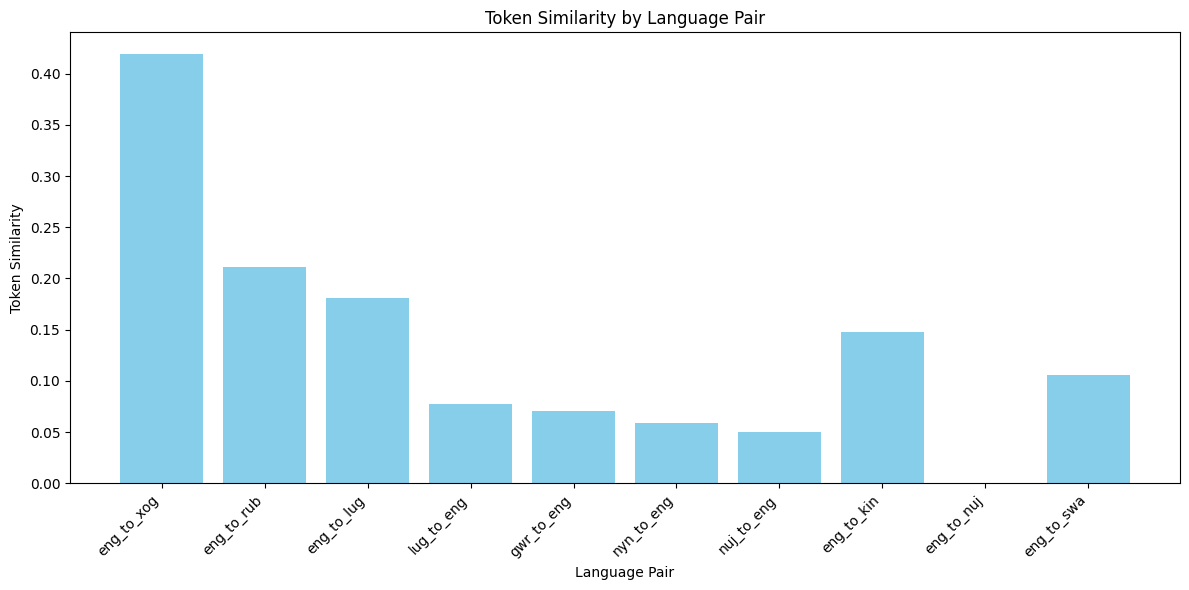

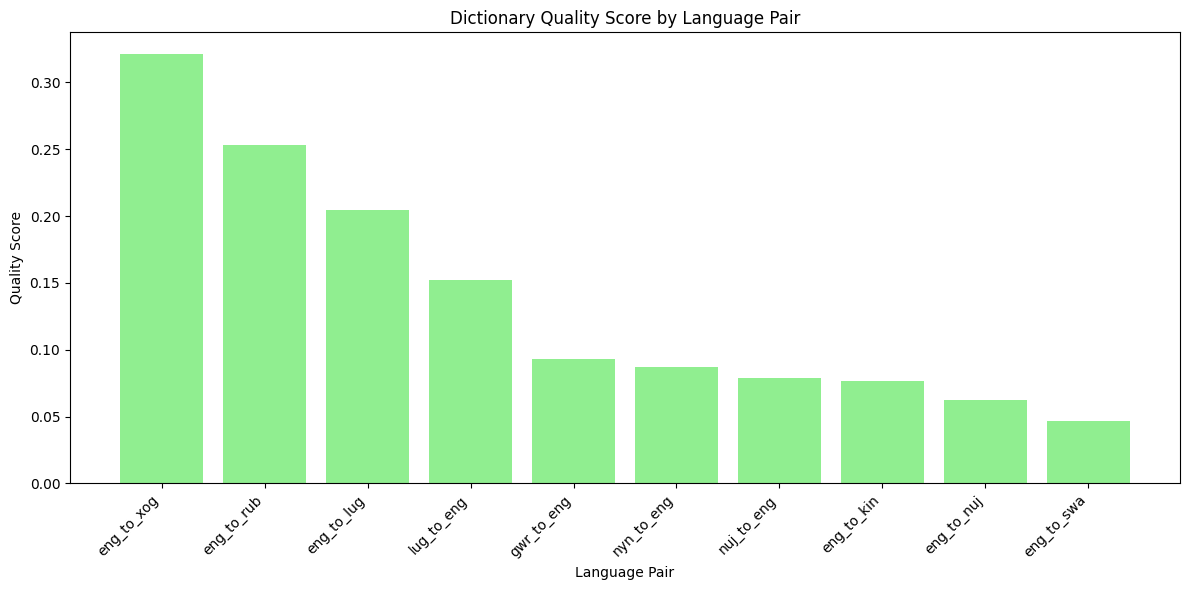

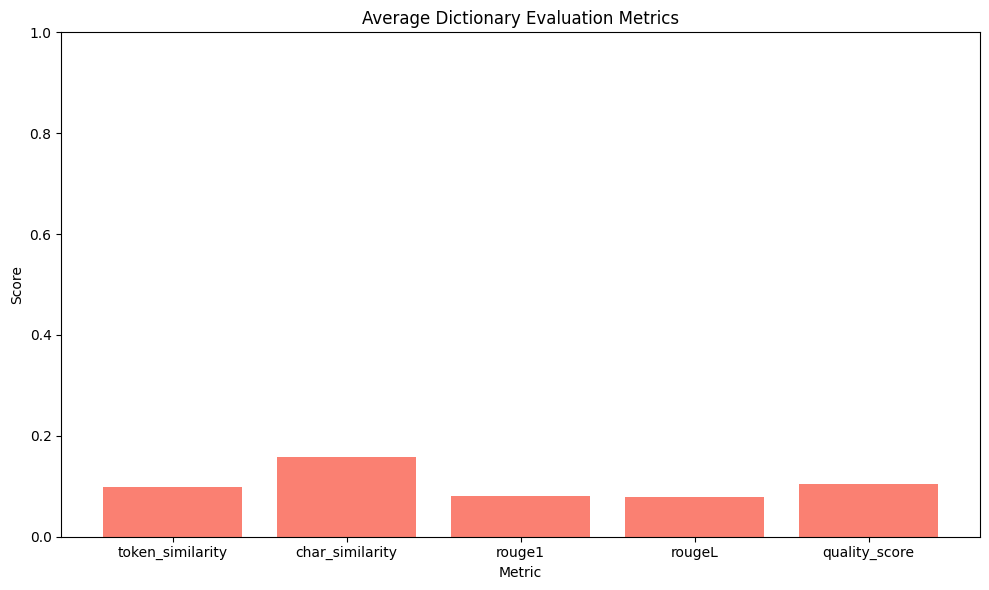

In [ ]:
plot_dictionary_metrics()

In [ ]:
# Save results
dict_results_path = f"{model_path.split('/')[-1]}_dictionary_metrics.json"
with open(dict_results_path, 'w') as f:
    json.dump(dict_metrics, f, indent=4)

print(f"Dictionary metrics saved to {dict_results_path}")

Dictionary metrics saved to Llama-3.2-3B-Instruct-UG40-16bit-refined-250307_dictionary_metrics.json


In [ ]:
# Display sample examples
print("\nSample Dictionary Evaluations:")
for i in range(min(5, len(dict_df))):
    print(f"\nTerm: {dict_df.iloc[i]['term']} ({dict_df.iloc[i]['from_language']} → {dict_df.iloc[i]['to_language']})")
    print(f"Reference: {dict_df.iloc[i]['reference']}")
    print(f"Prediction: {dict_df.iloc[i]['prediction']}")

from IPython.display import display
display(dict_df.head())


Sample Dictionary Evaluations:

Term: colostrum (eng → nuj)
Reference: omudooha
Prediction: amabbaali

Term: speak slyly (eng → nuj)
Reference: ohubbalangatania
Prediction: ohulomera mu hihyere

Term: nightjar, Fiery-necked (eng → nuj)
Reference: embugambugi
Prediction: omwenejere.

Term: die (eng → nuj)
Reference: ohubota endala
Prediction: ohufa, ohufa omuutu, ohufa omuutu omuhulu, ohufa omuutu omuhulu omuutu omuhulu ohufa omuutu omuhulu omuutu omuhulu ohufa omuutu omuhulu omuutu omuhulu ohufa omuutu omuhulu omuutu omuhulu ohufa omuutu omuh

Term: subtract numbers (eng → nuj)
Reference: ohubugula
Prediction: ohwawula amahulu.


term from_language to_language         reference  \
0               colostrum           eng         nuj          omudooha   
1             speak slyly           eng         nuj  ohubbalangatania   
2  nightjar, Fiery-necked           eng         nuj       embugambugi   
3                     die           eng         nuj    ohubota endala   
4        subtract numbers           eng         nuj         ohubugula   

                                          prediction  
0                                          amabbaali  
1                               ohulomera mu hihyere  
2                                        omwenejere.  
3  ohufa, ohufa omuutu, ohufa omuutu omuhulu, ohu...  
4                                  ohwawula amahulu.

In [ ]:
## Google translate Integraion

#https://github.com/ssut/py-googletrans

In [ ]:

!pip install googletrans


In [ ]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from googletrans import Translator
from googletrans import Translator, LANGUAGES

In [ ]:
gt_lang_map = {
    "eng": "en",
    "ach": "ach",
    "lug": "lg",
}

def is_supported(lang_code):
    mapped = gt_lang_map.get(lang_code)
    return mapped is not None and mapped in LANGUAGES


In [ ]:
async def _google_translate_all(texts, from_langs, to_langs):
    """
    Asynchronously translates a list of texts using Google Translate.
    For each text, maps our language codes to googletrans codes.
    If a language code is not supported, returns "N/A" for that text.
    """
    async with Translator() as translator:
        tasks = []
        for text, src, dest in zip(texts, from_langs, to_langs):
            src_mapped = gt_lang_map.get(src)
            dest_mapped = gt_lang_map.get(dest)
            if (src_mapped is None or dest_mapped is None or
                src_mapped not in LANGUAGES or dest_mapped not in LANGUAGES):
                # Append a dummy task returning "N/A"
                tasks.append(asyncio.sleep(0, result="N/A"))
            else:
                tasks.append(translator.translate(text, src=src_mapped, dest=dest_mapped))
        results = await asyncio.gather(*tasks)
        final_results = []
        for r in results:
            if hasattr(r, 'text'):
                final_results.append(r.text)
            else:
                final_results.append(r)
        return final_results

In [ ]:
def google_translate_fn(texts, from_langs, to_langs):
    """
    Synchronous wrapper for _google_translate_all.
    Returns a list of translated texts.
    """
    return asyncio.run(_google_translate_all(texts, from_langs, to_langs))

In [ ]:
# Filter the evaluation DataFrame for rows that are English <-> (Acholi or Luganda)
gt_mask = (
    ((translations['source.language'] == 'eng') & (translations['target.language'].isin(['ach', 'lug']))) |
    ((translations['target.language'] == 'eng') & (translations['source.language'].isin(['ach', 'lug'])))
)
gt_df = translations[gt_mask].copy()

In [ ]:
print("Generating Google Translate predictions for English <-> Acholi/Luganda...")
gt_texts = list(gt_df['source'])
gt_from_langs = list(gt_df['source.language'])
gt_to_langs = list(gt_df['target.language'])
gt_predictions = google_translate_fn(gt_texts, gt_from_langs, gt_to_langs)
gt_df['google_prediction'] = gt_predictions

# Create a new column in the main DataFrame with default "N/A" and update for the filtered rows.
translations['google_prediction'] = "N/A"
translations.loc[gt_df.index, 'google_prediction'] = gt_df['google_prediction']

print("Google Translate predictions added:")
print(translations.head())

Generating Google Translate predictions for English <-> Acholi/Luganda...
Google Translate predictions added:
                                              source  \
0  Tye yub mapat pat me nyayo lim i cing lwak ma ...   
1  Otita Lonyi eti otizani ꞌdiyi agrikica ma alia...   
2  Waliwo pulogulaamu nnyingi ez'okweggya mu bwav...   
3  Hariho puroguraamu nyingi z'okureetaho obugaig...   
4        Ipu ainapeta nuka adumun abar kotoma akoru.   

                                              target source.language  \
0  There are a number of wealth creation programs...             ach   
1  There are a number of wealth creation programs...             lgg   
2  There are a number of wealth creation programs...             lug   
3  There are a number of wealth creation programs...             nyn   
4  There are a number of wealth creation programs...             teo   

  target.language                                         prediction  \
0             eng  There are various income-gene

In [ ]:
translations

source  \
0    Tye yub mapat pat me nyayo lim i cing lwak ma ...   
1    Otita Lonyi eti otizani ꞌdiyi agrikica ma alia...   
2    Waliwo pulogulaamu nnyingi ez'okweggya mu bwav...   
3    Hariho puroguraamu nyingi z'okureetaho obugaig...   
4          Ipu ainapeta nuka adumun abar kotoma akoru.   
..                                                 ...   
595                  What were your research findings?   
596                  What were your research findings?   
597                  What were your research findings?   
598                  What were your research findings?   
599             Matokeo ya utafiti wako yalikuwa gani?   

                                                target source.language  \
0    There are a number of wealth creation programs...             ach   
1    There are a number of wealth creation programs...             lgg   
2    There are a number of wealth creation programs...             lug   
3    There are a number of wealth creation programs...             nyn   
4    There are a number of wealth creation programs...             teo   
..                                                 ...             ...   
595                      Okunoonyereza kwo kwazula ki?             eng   
596           Ebyarugire omukucondooza kwaawe nibiiha?             eng   
597            Aubo nu idumunit ijo kotoma aingic kon?             eng   
598             Matokeo ya utafiti wako yalikuwa gani?             eng   
599                  What were your research findings?             swa   

    target.language                                         prediction  \
0               eng  There are various income-generating activities...   
1               eng  There are many investment opportunities in the...   
2               eng  There are many poverty alleviation programs ce...   
3               eng    There are many programs to promote agriculture.   
4               eng  There are many ways of acquiring wealth in agr...   
..              ...                                                ...   
595             lug              Biki bye wazuula mu kunoonyereza kwo?   
596             nyn           Ebi waashangire omu kubuuririza nibiiha?   
597             teo           Anubo ajenuneta nuikamunitos aingicikon?   
598             swa              Matokeo ya utafiti wako ulikuwa yapi?   
599             eng            What were the results of your research?   

                                     google_prediction  
0    There are different ways of spreading funds to...  
1                                                  N/A  
2    There are many programs to lift themselves out...  
3                                                  N/A  
4                                                  N/A  
..                                                 ...  
595     Ebizuuliddwa mu kunoonyereza kwo byali biruwa?  
596                                                N/A  
597                                                N/A  
598                                                N/A  
599                                                N/A  

[600 rows x 6 columns]

In [ ]:
# Filter rows where google_prediction is not "N/A"
filtered_df = translations[translations['google_prediction'] != "N/A"]

In [ ]:
# Select columns to display: source text, source language, target language, model prediction, and google translate prediction
comparison_table = filtered_df[['source', 'source.language', 'target.language', 'prediction', 'google_prediction']]


In [ ]:

# Display the first few rows of the comparison table
comparison_table

source source.language  \
0    Tye yub mapat pat me nyayo lim i cing lwak ma ...             ach   
2    Waliwo pulogulaamu nnyingi ez'okweggya mu bwav...             lug   
5    There are a number of wealth creation programs...             eng   
7    There are a number of wealth creation programs...             eng   
12   Ginongo ngec ma lubbe ki kare me pit, gwoko ng...             ach   
..                                                 ...             ...   
583     The residents are not ready to leave the land.             eng   
588                  Adwoki me kwed ma megi obedo ngo?             ach   
590                      Okunoonyereza kwo kwazula ki?             lug   
593                  What were your research findings?             eng   
595                  What were your research findings?             eng   

    target.language                                         prediction  \
0               eng  There are various income-generating activities...   
2               eng  There are many poverty alleviation programs ce...   
5               ach              Tye yub mapol me kelo lonyo ki i pur.   
7               lug  Waliwo pulogulaamu nnyingi ez'okutondawo eby'o...   
12              eng  They acquired knowledge on planting, soil cons...   
..              ...                                                ...   
583             lug                Abatuuze tebeetegese kuva ku ttaka.   
588             eng            What were the results of your research?   
590             eng                       What did your research find?   
593             ach                       Adwoki me kwedoni obedo ngo?   
595             lug              Biki bye wazuula mu kunoonyereza kwo?   

                                     google_prediction  
0    There are different ways of spreading funds to...  
2    There are many programs to lift themselves out...  
5         tye ki yub me yubu lonyo mapol ma orumo pur.  
7    Waliwo enteekateeka eziwerako ez’okutondawo ob...  
12   They learn about the time of the plant, the ma...  
..                                                 ...  
583           Abatuuze tebali beetegefu kuva mu ttaka.  
588             What is the research on your research?  
590                   What did your research find out?  
593        Gin ango ma onongo kinongo i kwed ma itimo?  
595     Ebizuuliddwa mu kunoonyereza kwo byali biruwa?  

[200 rows x 5 columns]

In [ ]:
comparison_table.to_csv('google_vs_ug40llama3.1_comparison_table.csv', index=False)

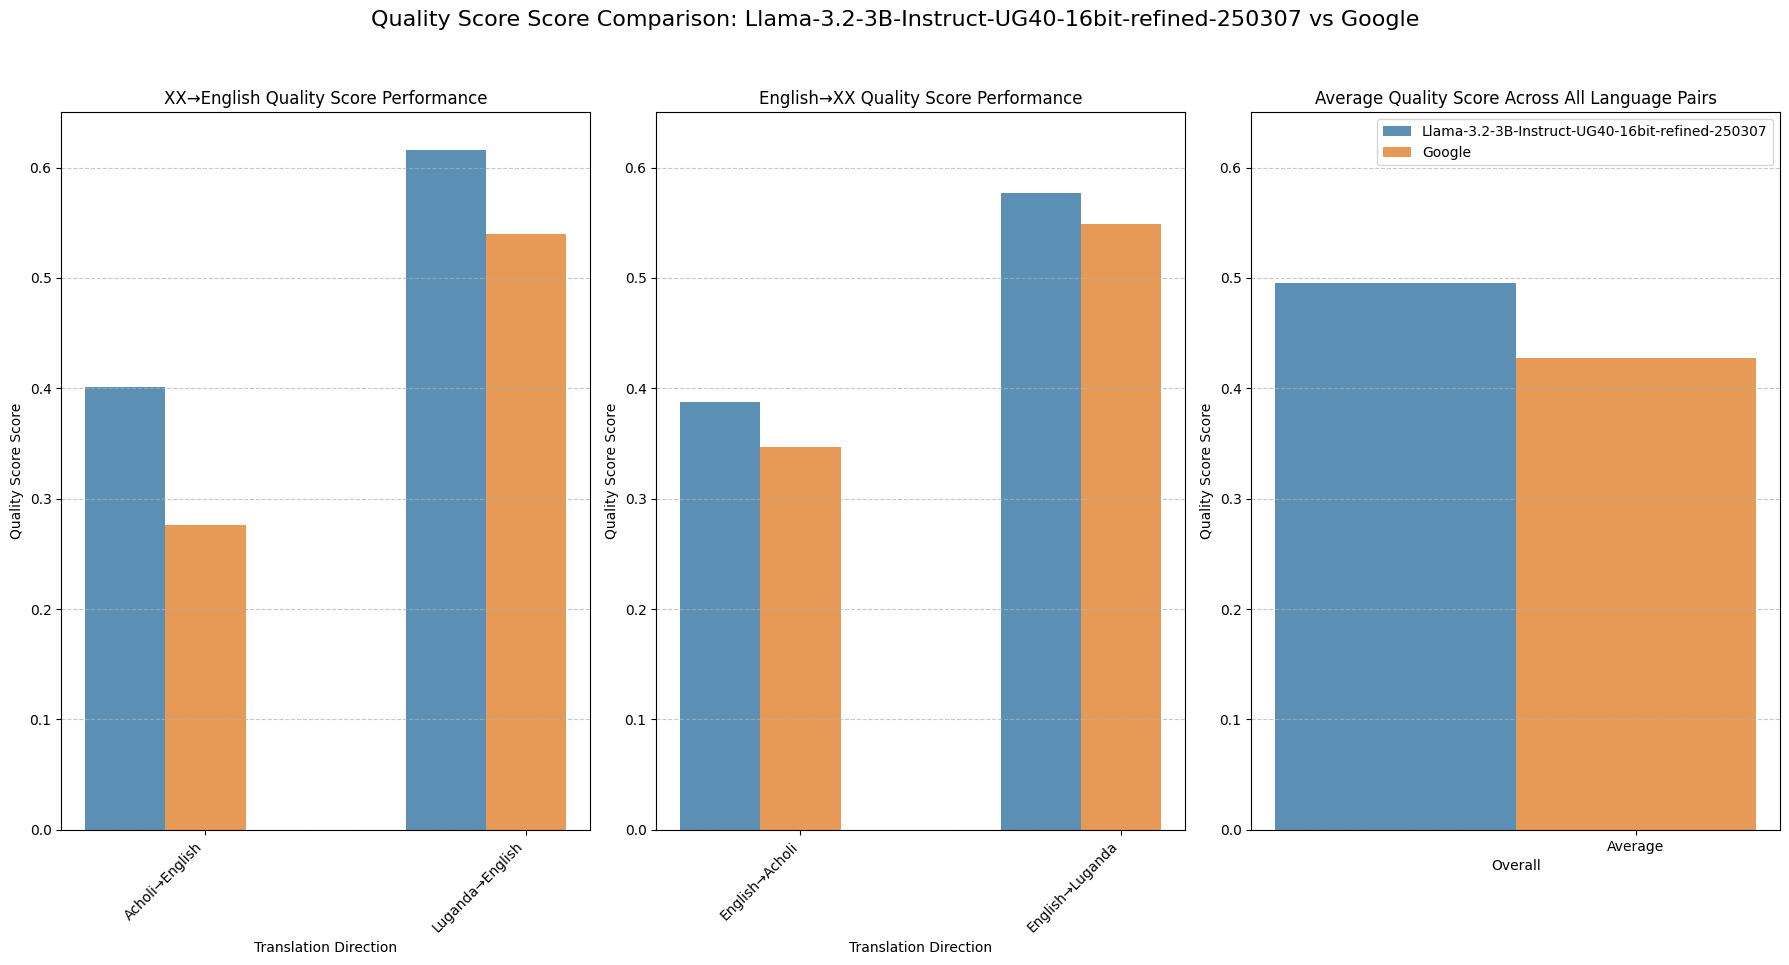

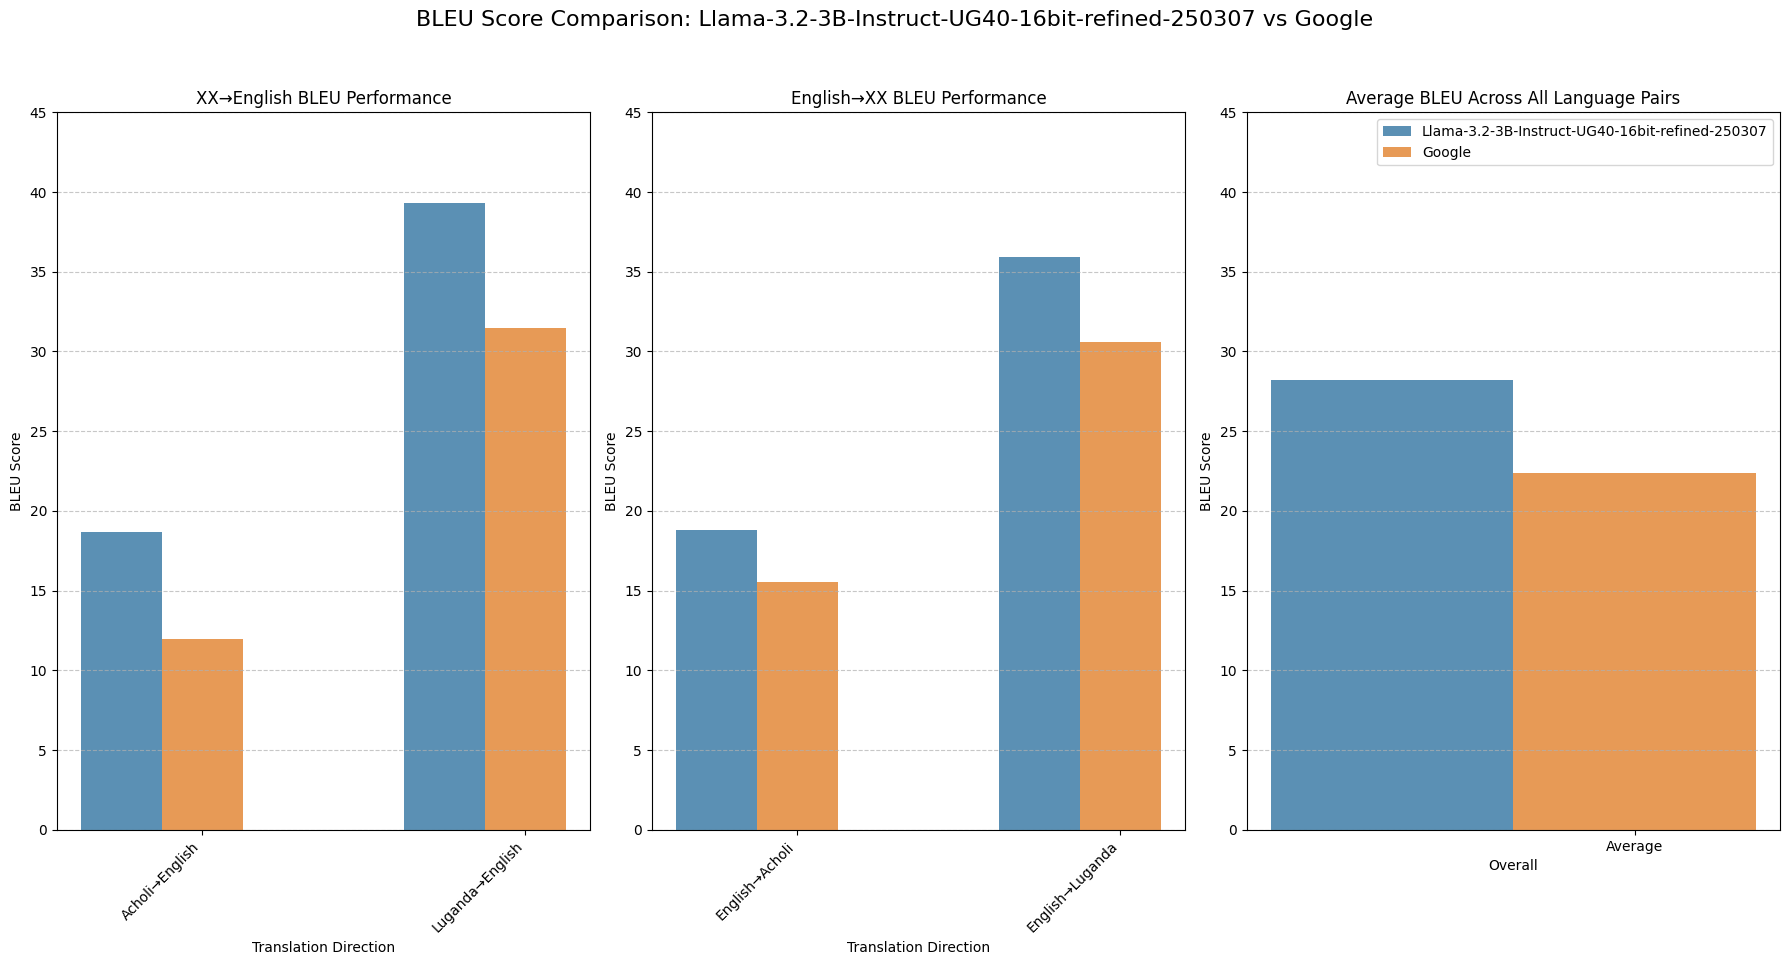

In [ ]:
# ----- Compute Metrics for Subset with Google Predictions -----
# Filter the DataFrame to rows where Google Translate predictions exist
subset_df = translations[translations['google_prediction'] != "N/A"]

# Group the subset for our model predictions
model_subset_translations = defaultdict(list)
for index, row in subset_df.iterrows():
    direction = row['source.language'] + '_to_' + row['target.language']
    model_subset_translations[direction].append(dict(row))

model_subset_grouped_metrics = defaultdict(dict)
for subset in model_subset_translations.keys():
    subset_metrics = defaultdict(list)
    for example in model_subset_translations[subset]:
        # Normalize both our model prediction and the reference
        pred_norm = normalizer(example['prediction'])
        ref_norm = normalizer(example['target'])
        m_metrics = calculate_metrics(ref_norm, pred_norm)
        for m in m_metrics:
            subset_metrics[m].append(m_metrics[m])
    for m in subset_metrics:
        model_subset_grouped_metrics[subset][m] = float(np.mean(subset_metrics[m]))
# Compute overall averages for our model on this subset
for m in subset_metrics.keys():
    vals = [model_subset_grouped_metrics[subset][m] for subset in model_subset_translations.keys()]
    model_subset_grouped_metrics['averages'][m] = float(np.mean(vals))

# Group the subset for Google Translate predictions
google_translation_subsets = defaultdict(list)
for index, row in subset_df.iterrows():
    direction = row['source.language'] + '_to_' + row['target.language']
    google_translation_subsets[direction].append(dict(row))

google_grouped_metrics = defaultdict(dict)
for subset in google_translation_subsets.keys():
    subset_metrics = defaultdict(list)
    for example in google_translation_subsets[subset]:
        # Normalize the google prediction and reference
        pred_norm = normalizer(example['google_prediction'])
        ref_norm = normalizer(example['target'])
        g_metrics = calculate_metrics(ref_norm, pred_norm)
        for m in g_metrics:
            subset_metrics[m].append(g_metrics[m])
    for m in subset_metrics:
        google_grouped_metrics[subset][m] = float(np.mean(subset_metrics[m]))
# Compute overall averages for Google predictions
for m in subset_metrics.keys():
    vals = [google_grouped_metrics[subset][m] for subset in google_translation_subsets.keys()]
    google_grouped_metrics['averages'][m] = float(np.mean(vals))

# Create a dictionary to hold metrics for both models
metrics_by_model = {
    "Llama-3.2-3B-Instruct-UG40-16bit-refined-250307": model_subset_grouped_metrics,
    "Google": google_grouped_metrics
}

# ----- Plot the Comparison -----
# (Reusing the previously defined plot_translation_metric_comparison function)
plot_translation_metric_comparison(metrics_by_model, metric='quality_score')
plot_translation_metric_comparison(metrics_by_model, metric='bleu')